In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
# Load the dataset
df = pd.read_csv('TSLA.csv')

end_date = datetime.datetime.now() 
start_date = end_date - datetime.timedelta(days = 365 * 5)
stock_data = yf.download('TSLA', start=start_date.date(), end=end_date.date())

# Use only the 'Close' column
data = pd.DataFrame(stock_data[['Open', 'Close', 'High', 'Low']].values, columns=['Open', 'Close', 'High', 'Low'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 1])
    return np.array(dataX), np.array(dataY)

# Define time step and split data
time_step = 100
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Reshape input to be [samples, time steps, features]
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 4)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 4)

[*********************100%***********************]  1 of 1 completed
(924, 100, 4)
(232, 100, 4)
(924,)
(232,)


In [3]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 4)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [4]:
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
15/15 [==============================] - 6s 169ms/step - loss: 0.0490 - val_loss: 0.0126
Epoch 2/100
15/15 [==============================] - 2s 103ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 3/100
15/15 [==============================] - 1s 98ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 4/100
15/15 [==============================] - 1s 97ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 5/100
15/15 [==============================] - 2s 105ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 6/100
15/15 [==============================] - 1s 98ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/100
15/15 [==============================] - 1s 95ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 8/100
15/15 [==============================] - 2s 104ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/100
15/15 [==============================] - 1s 97ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 10/100
15/15 [==============================] - 1s 99ms/step - loss: 0.0020 - val_loss: 0.

In [5]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error: ", mse)

temp = scaled_data[-232:]
temp[:, 1] = predictions.reshape(-1)
temp = scaler.inverse_transform(temp) # Undo scaling
predictions = temp[-232:, 1]

8/8 [==============================] - 1s 27ms/step
Mean Squared Error:  0.0006019944489577865


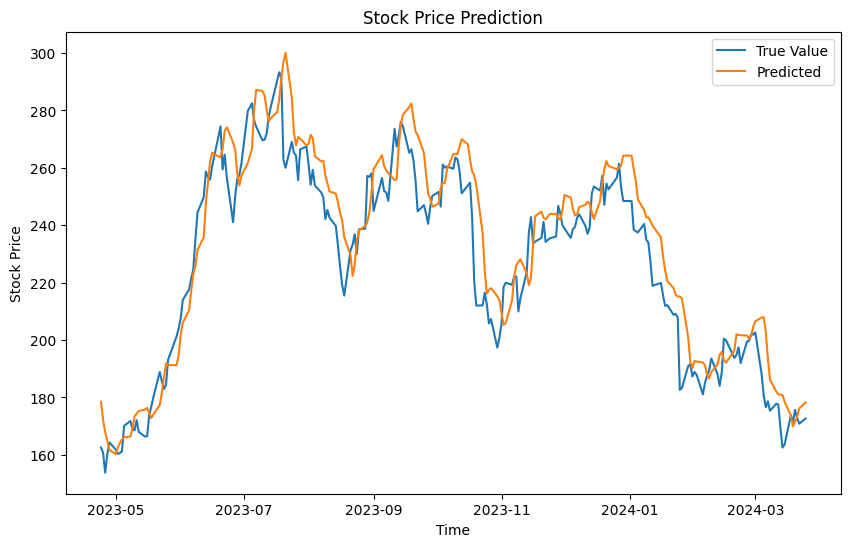

In [6]:
# plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='True Value')

# plt.plot(predictions, label='Predicted')


# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[-232:], stock_data['Close'].tail(232), label='True Value')
plt.plot(stock_data.index[-232:], predictions, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
